In [1]:
import numpy as np 
import tensorflow as tf

# **Encoder**

1) Embedding Layer

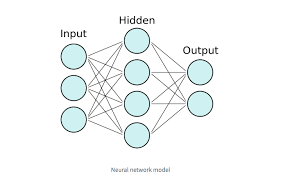

In [3]:
x=tf.Variable(np.random.random(size=(2,3)))
print(Embedding_Layer(x).shape)

(2, 3, 512)


2) Positional Encoding

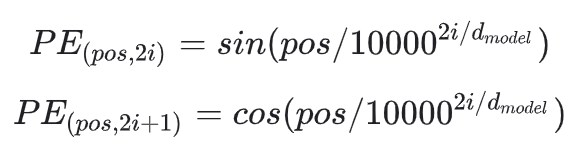

In [4]:
#create Positonal Encoding


def PositionalEncoding(position,dmodel):

  i=np.arange(dmodel)[np.newaxis,:]

  pos=np.arange(position)[:,np.newaxis]

  matrix = pos * (1/np.power(1000,2*(i/dmodel)))

  matrix[:,0::2]=np.sin(matrix[:,0::2])
  matrix[:,1::2]=np.cos(matrix[:,1::2])
  #(2 * (i//2)) / np.float32(d_model))

  return tf.cast(matrix[np.newaxis,:],dtype=tf.float32)

In [5]:
PositionalEncoding(3,512)

<tf.Tensor: shape=(1, 3, 512), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.6251037e-01,  8.1193745e-01, ...,
          1.0000000e+00,  1.0554496e-06,  1.0000000e+00],
        [ 9.0929741e-01, -3.6716419e-01,  9.4792795e-01, ...,
          1.0000000e+00,  2.1108992e-06,  1.0000000e+00]]], dtype=float32)>

3) Scaled Self Attention

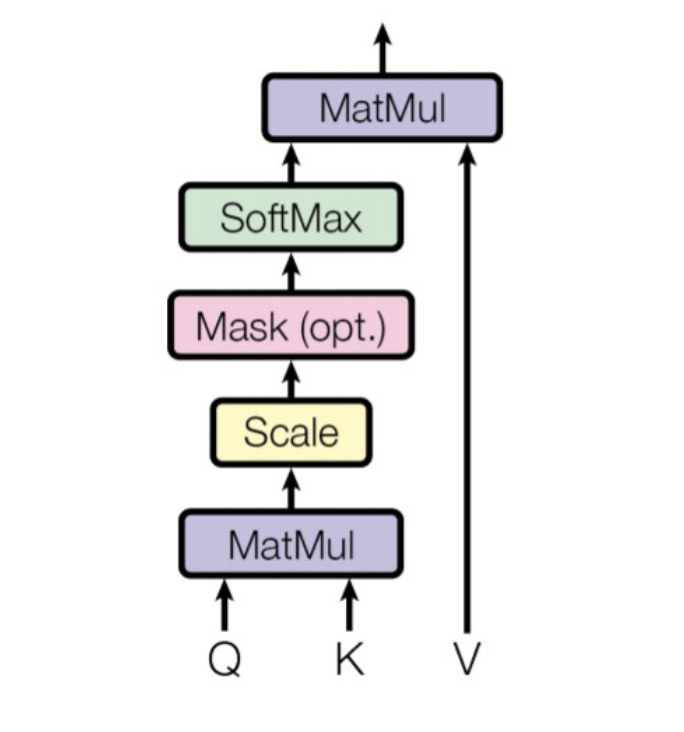

In [6]:
#input (batch_size,seq_len,embedding_size)


def Scaled_Self_Attention(q,k,v,mask):

  Match_keys=tf.matmul(q,k,transpose_b=True) #(batch_size,seq_len,embedding_size) * (batch_size,embedding_size,seq_len) = (batch_size,seq_len,seq_len)
 
  shape=tf.cast(tf.shape(q)[-1],dtype=tf.float32)

  Match_keys=Match_keys/ tf.math.sqrt(shape)

  if mask is not None:

    Match_keys+=mask*(-1e9)

  attention_weights=tf.nn.softmax(Match_keys,axis=-1)

  output=tf.matmul(attention_weights,v)  #(batch_size,seq_len,seq_len) * (batch_size,seq_len,embedding_size)=(batch_size,seq_len,embedding_size)

  return output ,attention_weights


In [7]:
q=tf.Variable([[10,0,0],[0,10,0],[0,0,10]],dtype=float)

Scaled_Self_Attention(q,q,q,None)

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1.000000e+01, 8.433274e-25, 8.433274e-25],
        [8.433274e-25, 1.000000e+01, 8.433274e-25],
        [8.433274e-25, 8.433274e-25, 1.000000e+01]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1.000000e+00, 8.433274e-26, 8.433274e-26],
        [8.433274e-26, 1.000000e+00, 8.433274e-26],
        [8.433274e-26, 8.433274e-26, 1.000000e+00]], dtype=float32)>)

4) MultiHeadAttention

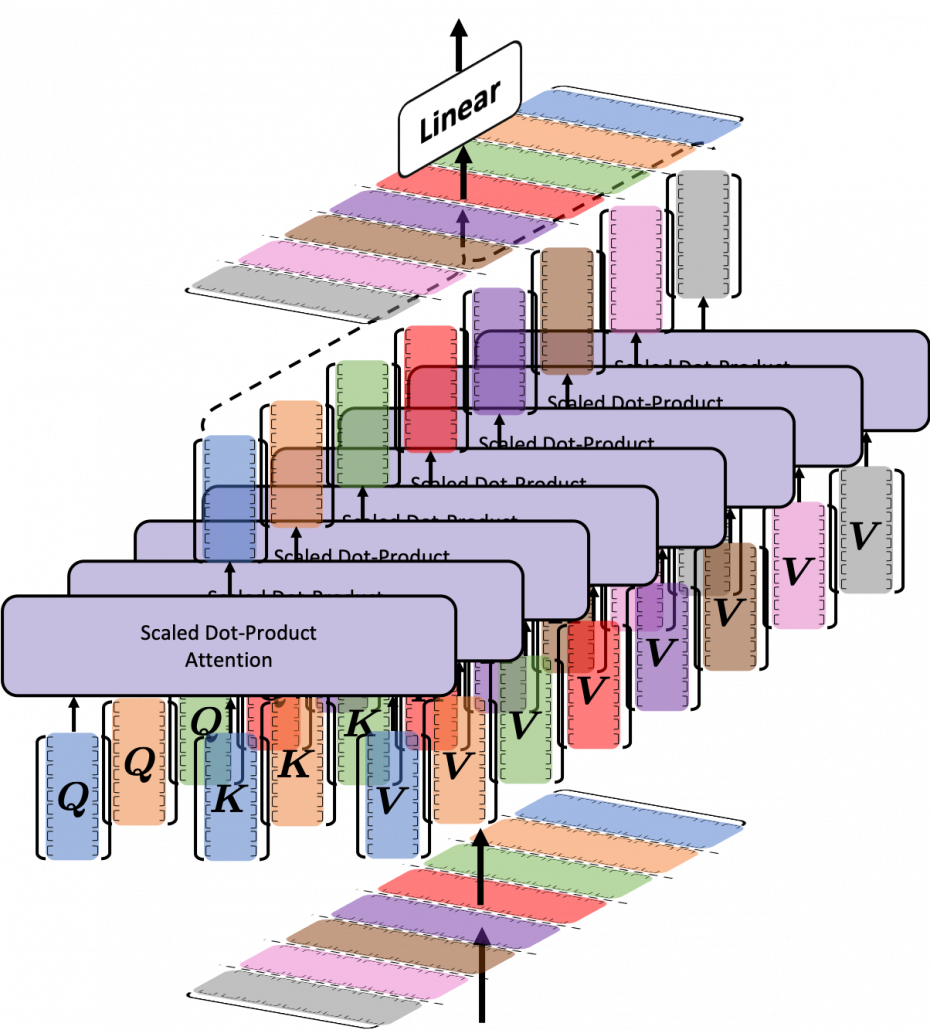

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self,num_heads,dmodel):
    super().__init__()
    self.num_heads=num_heads
    self.dmodel=dmodel

    self.depth=self.dmodel // self.num_heads

    self.wq=tf.keras.layers.Dense(self.dmodel)
    self.wk=tf.keras.layers.Dense(self.dmodel)
    self.wv=tf.keras.layers.Dense(self.dmodel)

    self.dense1 = tf.keras.layers.Dense(self.dmodel)

  def split_heads(self,x,batch_size): #(batch_size,seq_len,dmodel)
    
    reshape=tf.reshape(x,(batch_size,-1,self.num_heads,self.depth)) #(batch_size,seq_len,num_heads,depth)

    transpose=tf.transpose(reshape,perm=[0,2,1,3])  #(batch_size,num_heads,seq_len,depth)

    return transpose

  def call(self,q,k,v,mask): #(batch_size,seq_len,embedding_size)

    batch_size=tf.shape(q)[0] 

    q = self.wq(q)  #(batch_size,seq_len,dmodel)
    k = self.wk(k)  #(batch_size,seq_len,dmodel) 
    v = self.wv(v)  #(batch_size,seq_len,dmodel)

    split_head_q=self.split_heads(q,batch_size)  #(batch_size,num_heads,seq_len,depth)
    split_head_k=self.split_heads(k,batch_size)  #(batch_size,num_heads,seq_len,depth)
    split_head_v=self.split_heads(v,batch_size)  #(batch_size,num_heads,seq_len,depth)

    self_attention,attention_weights=Scaled_Self_Attention(split_head_q,split_head_k,split_head_v,mask)  #(batch_size,num_heads,seq_len,depth)
    transpose=tf.transpose(self_attention,perm=[0,2,1,3])
    concatenation = tf.reshape(transpose,(batch_size,-1,self.dmodel)) #(batch_size,seq_len,dmodel)
    dense =self.dense1(concatenation)
    return dense , attention_weights
    

In [9]:
temp_mha = MultiHeadAttention(dmodel=512, num_heads=8)
y = tf.random.uniform((64,43, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, y, y, mask=None)
out.shape, attn.shape

(TensorShape([64, 43, 512]), TensorShape([64, 8, 43, 43]))

In [10]:
len(temp_mha.trainable_weights)

8

In [11]:
print(temp_mha.trainable_weights)

[<tf.Variable 'multi_head_attention/dense/kernel:0' shape=(512, 512) dtype=float32, numpy=
array([[ 0.03122521, -0.0596232 , -0.04035144, ...,  0.03392077,
        -0.01669607,  0.02984132],
       [-0.0604279 ,  0.02150661,  0.05291191, ...,  0.0108011 ,
         0.05978895, -0.00889795],
       [-0.07115167,  0.00079405,  0.06206616, ..., -0.03901688,
         0.03124543,  0.07058802],
       ...,
       [ 0.02024855, -0.05705703,  0.04867137, ..., -0.01201852,
        -0.03288905, -0.04156102],
       [-0.01540927, -0.0210682 ,  0.05279107, ...,  0.0531434 ,
         0.07380437, -0.00324498],
       [-0.03342335,  0.00454193,  0.01562541, ..., -0.02984123,
         0.05161258,  0.03789002]], dtype=float32)>, <tf.Variable 'multi_head_attention/dense/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

5) Point wise Feed Forward Neural Network

In [12]:
def PWFFNN(dmodel,dff):
  
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(dmodel)  # (batch_size, seq_len, d_model)
  ])

6) Encoder Layer

In [13]:
class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self,num_heads,dmodel,dff,rate=0.1):
    super().__init__()
    self.mha = MultiHeadAttention(num_heads=num_heads,dmodel=dmodel)
    self.point_wise_ff_NN=PWFFNN(dmodel,dff)
   
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self,x,training,mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.point_wise_ff_NN(out1)  # (batch_size, input_seq_len, d_model)
  
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [14]:
sample_encoder_layer = EncoderLayer(dmodel=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [15]:
len(sample_encoder_layer.trainable_variables)

16

In [16]:
print(sample_encoder_layer.trainable_variables)

[<tf.Variable 'encoder_layer/multi_head_attention_1/dense_4/kernel:0' shape=(512, 512) dtype=float32, numpy=
array([[-0.04663205,  0.04919068, -0.04238268, ...,  0.02208153,
         0.05302224, -0.05959028],
       [-0.06709803, -0.03460752,  0.02507383, ...,  0.04849882,
        -0.02797681, -0.07054559],
       [ 0.01365222, -0.04670732, -0.03221072, ..., -0.02906346,
        -0.04330004, -0.06988804],
       ...,
       [ 0.00016849, -0.07120994,  0.00994108, ...,  0.05543985,
         0.01906595,  0.0570953 ],
       [-0.00422264, -0.01047716,  0.03159054, ...,  0.03269245,
         0.0190465 , -0.0733742 ],
       [-0.03539836, -0.00671196,  0.00270901, ...,  0.06760951,
        -0.00163952, -0.02198141]], dtype=float32)>, <tf.Variable 'encoder_layer/multi_head_attention_1/dense_4/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.

7) Encoder

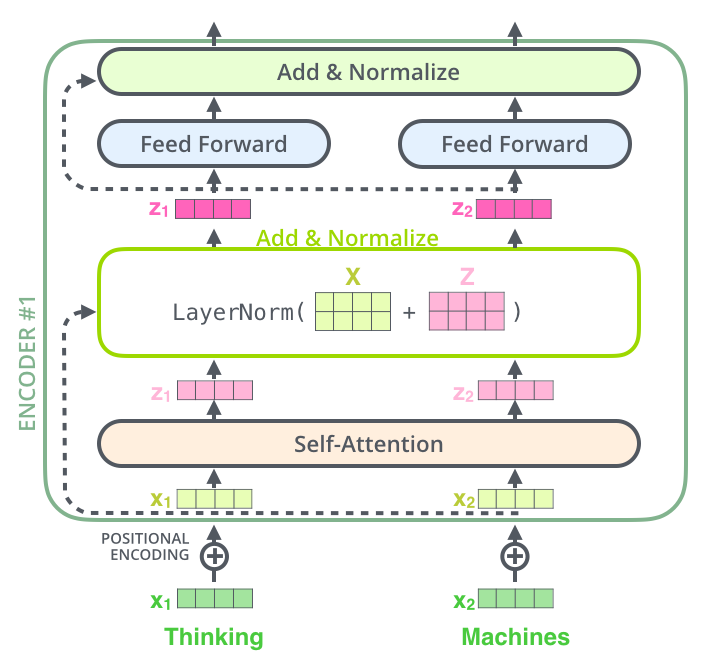

In [17]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self,num_heads,num_layers,dmodel,input_vocab,dff,pe_input,rate=0.1):
   
    super().__init__()
    self.num_heads=num_heads
    self.num_layers=num_layers
    self.dmodel=dmodel
    self.embedding_layer=tf.keras.layers.Embedding(input_vocab,dmodel)
    self.positional_Encoder=PositionalEncoding(pe_input,dmodel)

    self.layers=[EncoderLayer(num_heads=num_heads,dmodel=dmodel,dff=dff,rate=rate) for i in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  def call(self,x,training,mask):

    seq_len=tf.shape(x)[1]
    x=self.embedding_layer(x)
    x *= tf.math.sqrt(tf.cast(self.dmodel, tf.float32))
    x += self.positional_Encoder[:, :seq_len, :]

    for i in range(self.num_layers):
      x=self.layers[i](x,training,mask)

    return x




In [18]:
sample_encoder = Encoder(num_layers=2, dmodel=512, num_heads=8,
                         dff=2048, input_vocab=8500,pe_input=128)
temp_input = tf.random.uniform((64, 128), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape) 

(64, 128, 512)


In [19]:
len(sample_encoder.trainable_weights)

33

# **Decoder**

1) Decoder Layer

In [20]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,num_heads,dmodel, dff, rate=0.1):
    
    super().__init__()
    self.num_heads=num_heads
    self.dmodel=dmodel
    self.mha1 = MultiHeadAttention(dmodel=dmodel, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(dmodel=dmodel, num_heads=num_heads)

    self.ffn = PWFFNN(dmodel, dff)
    #self.p1 = tf.keras.layers.Dense(dff)
    #self.p2 = tf.keras.layers.Dense(dmodel)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,look_ahead_mask, padding_mask):

    m1,attention_weights1=self.mha1(x,x,x,look_ahead_mask) #(batch_Szie,seq_len,dmodel)

    attn_output = self.dropout1(m1, training=training)
    out1 = self.layernorm1(attn_output + x) 


    m2,attention_weights2=self.mha2(out1,enc_output,enc_output,padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(m2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    #pwf=self.p1(out1)
    #ffn_output=self.p2(pwf)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3,attention_weights2, attention_weights1

In [21]:
sample_decoder_layer = DecoderLayer(dmodel=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)


TensorShape([64, 50, 512])

2) Decoder

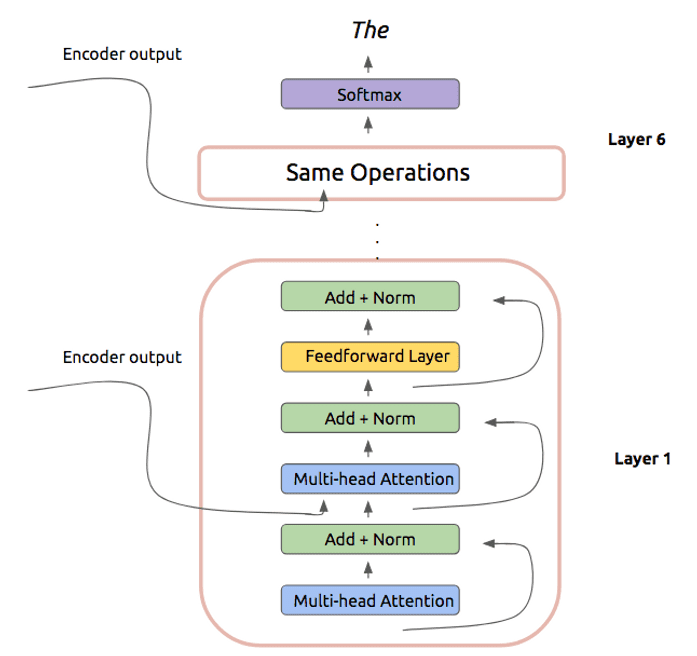

In [22]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self,num_heads,target_vocab_size,num_layers,dmodel,dff,pe_target,rate=0.1):

    super().__init__()
    self.num_heads=num_heads
    self.dmodel=dmodel
    self.num_layers=num_layers
    self.embedding_layer= tf.keras.layers.Embedding(target_vocab_size,dmodel)
    self.positional_encoder = PositionalEncoding(pe_target,dmodel)


    self.layers=[DecoderLayer(dmodel=dmodel,num_heads=num_heads,dff=dff,rate=rate) for i in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
      
      seq_len=tf.shape(x)[1]
      attention_weights=dict()
      x=self.embedding_layer(x)
      x *= tf.math.sqrt(tf.cast(self.dmodel, tf.float32))
      x += self.positional_encoder[:, :seq_len, :]
      
      for i in range(self.num_layers):
          x,block1,block2=self.layers[i](x,enc_output,training,look_ahead_mask,padding_mask)

          attention_weights[f'decoder_layer{i+1}_block1'] = block1
          attention_weights[f'decoder_layer{i+1}_block2'] = block2
     
      return x, attention_weights


In [23]:
sample_decoder = Decoder(num_layers=2, dmodel=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,pe_target=100)
temp_input = tf.random.uniform((64, 64), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 64, 512]), TensorShape([64, 8, 64, 64]))

# **Transformer**

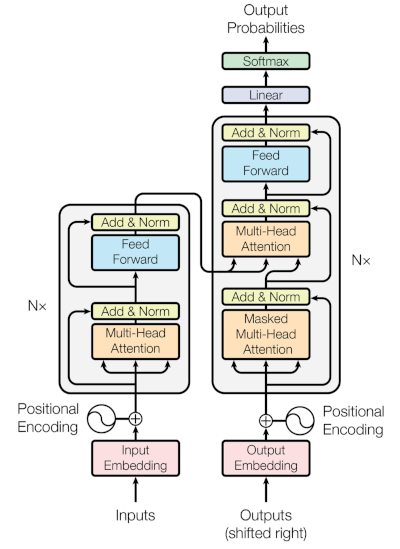

In [24]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

class Transformer(tf.keras.Model):

  def __init__(self,num_layers,num_heads,dmodel,dff,input_vocab_size,target_vocab_size,pe_input,pe_target,rate=0.1):
    super().__init__()
    self.encoder=Encoder(num_heads=num_heads,num_layers=num_layers,dmodel=dmodel,input_vocab=input_vocab_size,dff=dff,pe_input=pe_input,rate=rate)
    self.decoder=Decoder(num_heads=num_heads,target_vocab_size=target_vocab_size,num_layers=num_layers,dmodel=dmodel,dff=dff,pe_target=pe_target,rate=rate)
    self.Linear=tf.keras.layers.Dense(target_vocab_size)

  def create_masks(self, inp, tar):
    
    padding_mask = create_padding_mask(inp)
   
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

  def call(self,inputs,training):

     inp, tar = inputs

     padding_mask, look_ahead_mask = self.create_masks(inp, tar)

     enc_output = self.encoder(inp, training, padding_mask)

     dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, padding_mask)

     final_output = self.Linear(dec_output)

     return final_output, attention_weights


In [25]:
sample_transformer = Transformer(num_layers=2, dmodel=512, num_heads=8, dff=2048,input_vocab_size=8500, target_vocab_size=8000,pe_input=100,pe_target=100)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64,36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [26]:
len(sample_transformer.trainable_variables)

88

**Optimizer**

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
dmodel=128
learning_rate = CustomSchedule(dmodel)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

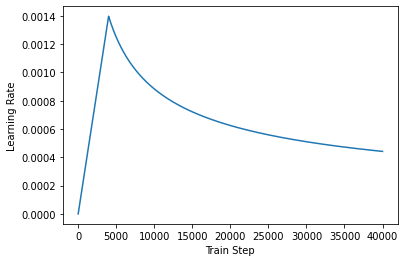

In [29]:

import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(dmodel)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

**Loss and Accuracy Metrics**

 1) Loss Metrics

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true,y_pred):

  #creating padding mask (padding not contributed to output we can remove those padded words from loss)

  mask=tf.math.logical_not(tf.math.equal(y_true,0))
  
  loss=loss_object(y_true ,y_pred)
 
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss*=mask

  return tf.reduce_sum(loss)/tf.reduce_sum(mask)

2) Accuracy


In [31]:
def accuracy(y_true,y_pred):
  mask=tf.math.logical_not(tf.math.equal(y_true,0))

  acc=tf.equal(y_true, tf.argmax(y_pred, axis=2))

  accuracies=tf.math.logical_and(acc,mask)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)



## **Creating Dataset**

In [32]:
import tensorflow_datasets as tfds

In [33]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0T0BJP/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0T0BJP/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0T0BJP/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [34]:
len(train_examples)

51785

In [35]:
for i, (p,e) in enumerate(train_examples):
  print("portugese")
  print(p)
  print("English")
  print(e)
  if i==3:
    break

portugese
tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
English
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)
portugese
tf.Tensor(b'mas e se estes fatores fossem ativos ?', shape=(), dtype=string)
English
tf.Tensor(b'but what if it were active ?', shape=(), dtype=string)
portugese
tf.Tensor(b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .', shape=(), dtype=string)
English
tf.Tensor(b"but they did n't test for curiosity .", shape=(), dtype=string)
portugese
tf.Tensor(b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .', shape=(), dtype=string)
English
tf.Tensor(b'and this conscious defiance is why i , as an agnostic , can still have faith .', shape=(), dtype=string)


building subword tokenizer

In [36]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),   target_vocab_size=2**13)

In [37]:
sample="East or West i am the best"

tokenizer_en.encode(sample)

[7900, 2052, 7863, 50, 7918, 956, 12, 313, 3, 2881]

In [38]:
tokenizer_en.decode(tokenizer_en.encode(sample))

'East or West i am the best'

In [39]:
def add_start_end_tokens(pt , en):

  pt=[tokenizer_pt.vocab_size]+tokenizer_pt.encode(pt.numpy())+[tokenizer_pt.vocab_size+1]
  en=[tokenizer_en.vocab_size]+tokenizer_en.encode(en.numpy())+[tokenizer_en.vocab_size+1]

  return pt , en

In [40]:
for i , j in train_examples:
  print(add_start_end_tokens(i,j))
  break;

([8214, 6, 40, 4092, 57, 3, 1687, 1, 6155, 12, 3, 461, 6770, 19, 5227, 1088, 97, 1, 5, 8, 3, 4213, 3408, 7256, 1670, 2, 8215], [8087, 4, 59, 15, 1792, 6561, 3060, 7952, 1, 15, 103, 134, 378, 3, 47, 6122, 6, 5311, 1, 91, 13, 1849, 559, 1609, 894, 2, 8088])


In [41]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(add_start_end_tokens, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [42]:
Max_tokens = 40
def filter_max_length(x, y, max_length=Max_tokens):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [43]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE) #,padded_shapes=([Max_tokens],[Max_tokens]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [44]:
for i,(inp, tar) in enumerate(train_dataset):
  if i==1:
    print(inp,tar)
    break

tf.Tensor(
[[8214   59 2815 ...    0    0    0]
 [8214    6 3246 ...    0    0    0]
 [8214 1301  353 ...    0    0    0]
 ...
 [8214  216    8 ...    0    0    0]
 [8214   76 1647 ...    0    0    0]
 [8214    6    8 ...    0    0    0]], shape=(64, 39), dtype=int64) tf.Tensor(
[[8087   16  618 ...    0    0    0]
 [8087    4  105 ...    0    0    0]
 [8087 6516 7863 ...    0    0    0]
 ...
 [8087  196    8 ...    0    0    0]
 [8087   14   31 ...    0    0    0]
 [8087    4   17 ...    0    0    0]], shape=(64, 39), dtype=int64)


In [45]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

Transformer

In [46]:
num_layers = 4
dmodel = 128
dff = 512
num_heads = 8
dropout_rate = 0.2
input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
tf.keras.backend.clear_session()
transformer =Transformer(num_layers=num_layers, dmodel=dmodel, num_heads=num_heads, dff=dff,input_vocab_size=input_vocab_size, \
                         target_vocab_size=target_vocab_size,pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,rate=dropout_rate)

In [47]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy =  tf.keras.metrics.Mean(name='train_accuracy')
#train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)

  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(accuracy(tar_real, predictions))

check points

In [48]:
checkpoint_path = './checkpoints/train1'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [50]:
import time
for epoch in range(20):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.0288 Accuracy 0.2489
Epoch 1 Batch 50 Loss 5.0822 Accuracy 0.2544
Epoch 1 Batch 100 Loss 5.0528 Accuracy 0.2584
Epoch 1 Batch 150 Loss 5.0363 Accuracy 0.2613
Epoch 1 Batch 200 Loss 5.0021 Accuracy 0.2646
Epoch 1 Batch 250 Loss 4.9790 Accuracy 0.2671
Epoch 1 Batch 300 Loss 4.9538 Accuracy 0.2700
Epoch 1 Batch 350 Loss 4.9273 Accuracy 0.2729
Epoch 1 Batch 400 Loss 4.9052 Accuracy 0.2753
Epoch 1 Batch 450 Loss 4.8851 Accuracy 0.2775
Epoch 1 Batch 500 Loss 4.8640 Accuracy 0.2798
Epoch 1 Batch 550 Loss 4.8449 Accuracy 0.2818
Epoch 1 Batch 600 Loss 4.8270 Accuracy 0.2837
Epoch 1 Batch 650 Loss 4.8090 Accuracy 0.2855
Epoch 1 Batch 700 Loss 4.7898 Accuracy 0.2874
Epoch 1 Loss 4.7895 Accuracy 0.2875
Time taken for 1 epoch: 42.65176320075989 secs

Epoch 2 Batch 0 Loss 4.5552 Accuracy 0.3243
Epoch 2 Batch 50 Loss 4.4574 Accuracy 0.3194
Epoch 2 Batch 100 Loss 4.4473 Accuracy 0.3191
Epoch 2 Batch 150 Loss 4.4422 Accuracy 0.3191
Epoch 2 Batch 200 Loss 4.4352 Accuracy 0.3194
Ep

### Inference

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
class Translater:

  def __init__(self,tokenizer_en,tokenizer_pt,model):

    self.tokenizer_en=tokenizer_en
    self.tokenizer_pt=tokenizer_pt
    self.model=model

  def __call__(self,pt,ground_truth,max_length):

    start_token=self.tokenizer_en.vocab_size
    encode_input=[self.tokenizer_pt.vocab_size]+self.tokenizer_pt.encode(pt)+[tokenizer_pt.vocab_size+1]

    end_token=tokenizer_en.vocab_size+1

    tokens=[start_token]


    for i in range(max_length):

      predicted,attention_weights = self.model([np.array([encode_input]),np.array([tokens])])
      
      if np.argmax(predicted[:,-1,:][0])!=end_token:
         tokens.append(np.argmax(predicted[:,-1,:][0]))
      
      else:
        break;

    xlabel=['start']+[tokenizer_pt.decode([i]) for i in encode_input[1:-1]]+['end']

    ylabel=[tokenizer_en.decode([i]) for i in tokens[1:]]+['end']

    sns.heatmap(list(attention_weights.items())[0][1][0,0,:],cmap='Blues',xticklabels=xlabel,yticklabels=ylabel)
    plt.title("head-1")
    plt.show()
    sns.heatmap(list(attention_weights.items())[1][1][0,0,:],cmap='Blues',xticklabels=xlabel,yticklabels=ylabel)
    plt.title("head-2")
    plt.show()
    sns.heatmap(list(attention_weights.items())[2][1][0,0,:],cmap='Blues',xticklabels=xlabel,yticklabels=ylabel)
    plt.title("head-3")
    plt.show()
    print("Portugues :",pt)
    print("predicted :",self.tokenizer_en.decode(tokens[1:]))
    print("Ground Truth :",ground_truth)




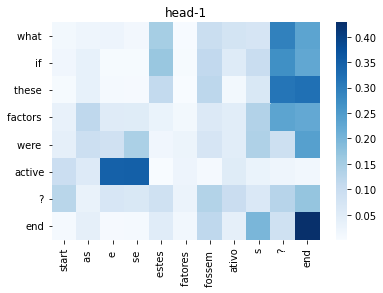

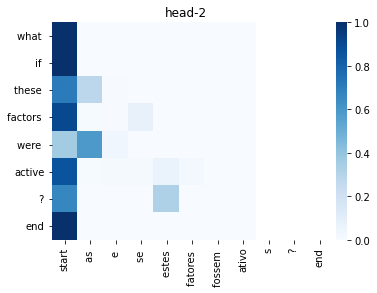

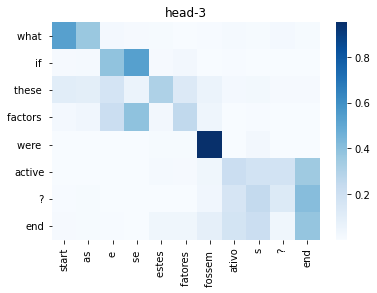

Portugues : as e se estes fatores fossem ativos ?
predicted : what if these factors were active ?
Ground Truth : but what if it were active ?


In [235]:
x='as e se estes fatores fossem ativos ?'
y='but what if it were active ?'

translate=Translater(tokenizer_en,tokenizer_pt,transformer)
translate(x,y,30)

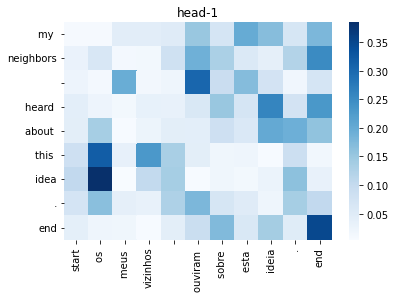

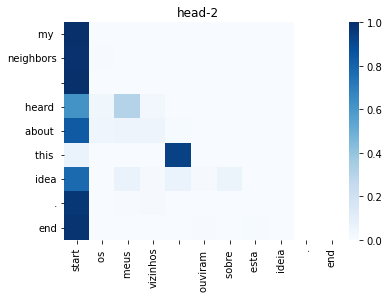

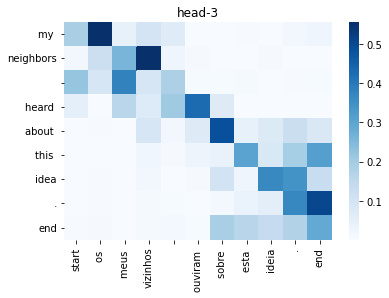

Portugues : os meus vizinhos ouviram sobre esta ideia.
predicted : my neighbors heard about this idea .
Ground Truth : and my neighboring homes heard about this idea .


In [236]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'
translate(sentence ,ground_truth,30)

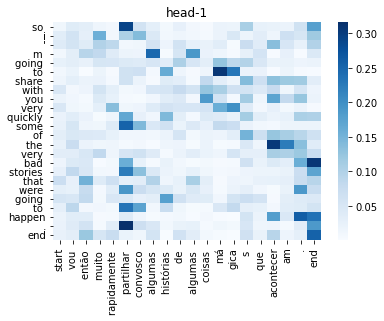

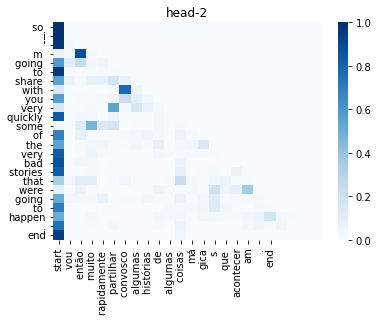

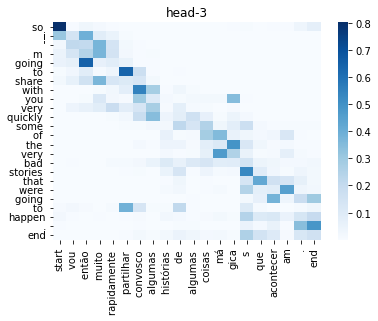

Portugues : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
predicted : so i 'm going to share with you very quickly some of the very bad stories that were going to happen .
Ground Truth : so i'll just share with you some stories very quickly of some magical things that have happened.


In [237]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."
translate(sentence ,ground_truth,1000)

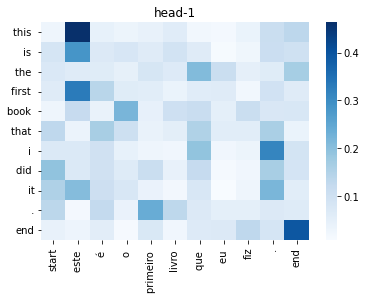

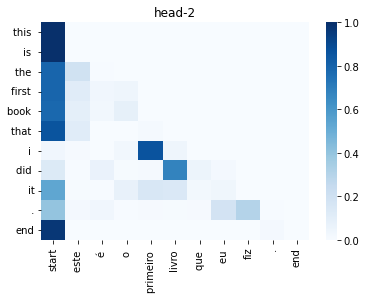

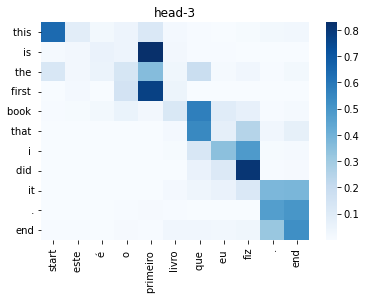

Portugues : este é o primeiro livro que eu fiz.
predicted : this is the first book that i did it .
Ground Truth : this is the first book i've ever done.


In [238]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."
translate(sentence ,ground_truth,1000)